In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Embedding
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import os
import pandas

Using TensorFlow backend.


In [5]:
def normalize(df):
    norm_df = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in norm_df.columns: 
        norm_df[col] = min_max_scaler.fit_transform(norm_df[col].values.reshape(-1,1))
    return norm_df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [6]:
def genInputTrain(df, pastDay=30, futureDay=5,feature='close',profit=0.03,drop=False):
    X_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        if drop:
            X_train.append(np.array(df.drop(['open','adj_close','close','high','low'],axis=1).iloc[i:i+pastDay]))
        else:
            X_train.append(np.array(df.iloc[i:i+pastDay]))
        
    return np.array(X_train)

def genOutputTrain(df,pastDay=30, futureDay=5,feature='close',profit=0.03):
    Y_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        #high_close = max(df.iloc[i+pastDay+1:i+pastDay+futureDay][feature])
        ave_close = np.mean(np.array(df.iloc[i+pastDay:i+pastDay+futureDay][feature]))
        #sub_y = (high_close-df.iloc[i+pastDay][feature])/df.iloc[i+pastDay][feature]
        sub_y = (ave_close-df.iloc[i+pastDay][feature])/df.iloc[i+pastDay][feature]
        Y_train.append(np.array([float(sub_y>profit)]))
        
    return np.array(Y_train)

def genInputTest(df, pastDay=30, feature='close',profit=0.03,drop=False):
    X_train = []
    for i in range(df.shape[0]-pastDay):
        if drop:
            X_train.append(np.array(df.drop(['open','adj_close','close','high','low'],axis=1).iloc[i:i+pastDay]))
        else:
            X_train.append(np.array(df.iloc[i:i+pastDay]))
        
    return np.array(X_train)

In [41]:
def buildModel(shape):
    print ('Creating model...')
    model = Sequential()
    #model.add(Embedding(input_dim = shape[2], output_dim = 50, input_length = shape[1]))
    model.add(LSTM(2*shape[2], activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(2*shape[2], activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model
def buildModel2(shape):
    model = Sequential()
    model.add(LSTM(units = 256,  input_shape = (shape[1], shape[2])))
    '''
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    '''
   
    model.add(Dense(units = 1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildModel3(shape):
    model = Sequential()
    model.add(LSTM(units = 24,  input_shape = (shape[1], shape[2]),return_sequences = True))
    model.add(Dense(units = 48, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units = 48))
    model.add(Dense(units = 24, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    #model.compile(loss="mse", optimizer="adam")
    model.compile(loss='mean_absolute_error',optimizer="adam")
    model.summary()
    return model

In [53]:
def plot_stock(actual):
    plt.plot(actual, color='blue', label='actual')
    plt.legend(loc='best')
    plt.show()
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [54]:
def accuracy(df,model,past=30,future=5,profit=0.03,threshold=0.5,drop=False):

    Y_test=genOutputTrain(df, past,future,profit=profit)
    df_norm=normalize(df)
    X_test=genInputTrain(df_norm, past,future,drop=drop)
    result = model.predict(X_test)
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(result)):
        if Y_test[i,0] >0.5  and result[i]>=threshold:
            TP += 1
        elif Y_test[i,0] <0.5 and result[i]>=threshold:
            FP += 1
        elif Y_test[i,0] <0.5 and result[i]<threshold:
            TN += 1
        else:
            FN += 1
    print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
    print(TP/(TP+FP))
    print('')
            
            

    

In [64]:
def save_model(model,name):
    model.save(os.path.join(os.getcwd(),"models",name))
def load_model(name):
    return load_model(os.path.join(os.getcwd(),"models",name))

In [14]:
#with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
#    df = pickle.load(f).iloc[:-60]
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        print(train_data)
        
        sub_df=pickle.load(f)#.iloc[:-60]
        #print((sub_df.columns))
        #sub_df.replace([np.inf, -np.inf], np.nan,inplace=True)
        #print(sub_df.isna().sum())
        all_df.append(sub_df)

df = pd.concat(all_df,axis=0, ignore_index=True)

past = 30
future = 5
Y_train=genOutputTrain(df, past,future,profit=0.03)
df_norm=normalize(df)
X_train=genInputTrain(df_norm, past,future,drop=True)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.33)

1203.pickle
1217.pickle
2885.pickle
1218.pickle
2609.pickle
2498.pickle
2881.pickle
3034.pickle
2353.pickle
2449.pickle
1444.pickle
2308.pickle
2412.pickle
1216.pickle
3045.pickle
3008.pickle
2884.pickle
2504.pickle
1301.pickle
2344.pickle
3443.pickle
2505.pickle
2454.pickle
2330.pickle
1201.pickle
2618.pickle
2603.pickle
1707.pickle
2303.pickle
2201.pickle
2610.pickle
2889.pickle
1215.pickle
2891.pickle
2368.pickle
2892.pickle
2103.pickle
0050.pickle
1734.pickle
2337.pickle
2886.pickle


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Epoch 1/1000
775/775 [==============================] - 29s 38ms/step - loss: 0.3009 - accuracy: 0.9166 - val_loss: 0.2736 - val_accuracy: 0.9192
Epoch 2/1000
775/775 [==============================] - 28s 36ms/step - loss: 0.2883 - accuracy: 0.9186 - val_loss: 0.2713 - val_accuracy: 0.9192
Epoch 3/1000
775/775 [==============================] - 28s 36ms/step - loss: 0.2821 - accuracy: 0.9186 - val_loss: 0.2752 - val_accuracy: 0.9192
Epoch 4/1000
775/775 [==============================] - 28s 36ms/step - loss: 0.2760 - accuracy: 0.9186 - val_loss: 0.2653 - val_accuracy: 0.9192
Epoch 5/1000
775/775 [==============================] - 28s 36ms/step - loss: 0.2732 - accuracy: 0.9186 - val_loss: 0.2651 - val_accuracy: 0.9192
Epoch 6/1000
775/775 [==============================] - 29s 37ms/step - loss: 0.2701 - accuracy: 0.9186 - val_loss: 0.2635 - val_accuracy: 0.9192
Epoch 7/1000
775/775 [==============================] - 28s 37ms/step - loss: 0.2681 - accuracy: 0.9186 - val_loss: 0.2624 -

775/775 [==============================] - 31s 40ms/step - loss: 0.2379 - accuracy: 0.9214 - val_loss: 0.2419 - val_accuracy: 0.9208
Epoch 57/1000
775/775 [==============================] - 30s 39ms/step - loss: 0.2375 - accuracy: 0.9209 - val_loss: 0.2431 - val_accuracy: 0.9213
Epoch 58/1000
775/775 [==============================] - 30s 39ms/step - loss: 0.2373 - accuracy: 0.9213 - val_loss: 0.2440 - val_accuracy: 0.9209
Epoch 59/1000
775/775 [==============================] - 30s 39ms/step - loss: 0.2365 - accuracy: 0.9210 - val_loss: 0.2417 - val_accuracy: 0.9218
Epoch 60/1000
775/775 [==============================] - 30s 39ms/step - loss: 0.2358 - accuracy: 0.9215 - val_loss: 0.2431 - val_accuracy: 0.9214
Epoch 61/1000
775/775 [==============================] - 31s 40ms/step - loss: 0.2352 - accuracy: 0.9217 - val_loss: 0.2422 - val_accuracy: 0.9211
Epoch 62/1000
775/775 [==============================] - 31s 40ms/step - loss: 0.2346 - accuracy: 0.9214 - val_loss: 0.2432 - val_ac

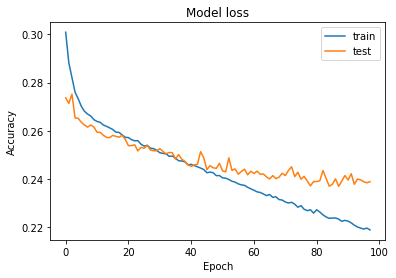

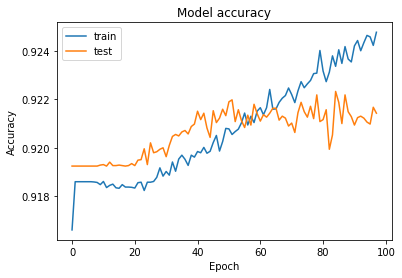

In [42]:
model = buildModel3(X_train.shape)
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history=model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])
training_result(history)

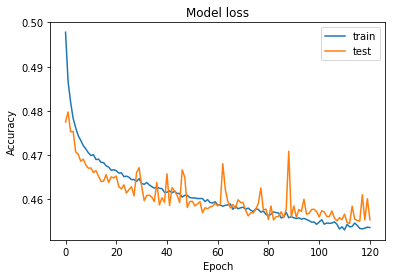

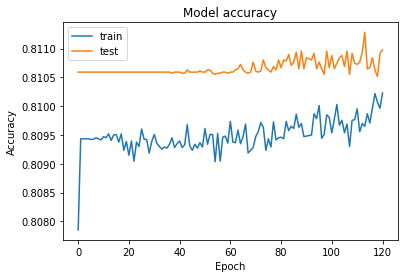

In [38]:
training_result(history)

(3608, 1)
(3608, 30, 24)


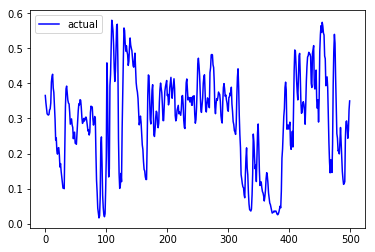

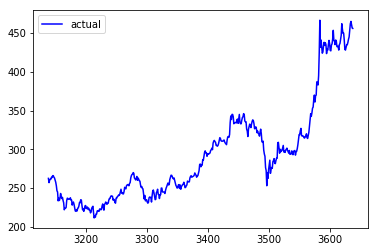

In [50]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
#print(df.head())
df_norm=normalize(df)
#X_train, Y_train = buildTrain(df_norm, 60, 5)
X_test = genInputTest(df_norm,30,drop=True)
result = model.predict(X_test)
#print(result[-40:])

print(result.shape)
print(X_test.shape)
plot_stock(result[-500:])
plot_stock(df['high'][-500:])

In [36]:
print(X_train[0,0,:])
print(Y_train.shape)

[0.00182796 0.58292794 0.58078722 0.5428655  0.00408419 0.00421842
 0.12510901 0.00409167 0.00420835 0.00456461 0.00395886 0.00437928
 0.         0.59690238 0.00356659 0.21162771 0.         0.26666667
 0.00200483 0.00070827 0.45454545 0.00101249 0.2        0.64285714]
(99179, 1)


In [56]:

with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f).iloc[:]
    
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        #print(train_data)
        sub_df=pickle.load(f)#.iloc[:-60]
        all_df.append(sub_df)

df = pd.concat(all_df,axis=0, ignore_index=True)
print(df.tail())
#print(df.columns)
#print(df.head())
#print(df.tail())
past = 30
future = 5
thre = 0.1
while thre < 1.0:
    accuracy(df[-500:],model,past=past,future=future,profit=0.03,threshold=thre,drop=True)
    thre+=0.1
#accuracy(df,model,past=30,future=5,profit=0.02,threshold=9.9)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


           D       DEM       DIF   Dif     EMA_12     EMA_26         K  \
592243  0.00 -0.534527 -0.416605  0.25  28.031831  28.448436  0.803419   
592244  0.10 -0.502885 -0.376319 -0.10  28.050011  28.426329  0.797517   
592245  0.15 -0.472795 -0.352433 -0.15  28.042317  28.394750  0.698345   
592246  0.25 -0.448165 -0.349645 -0.25  27.997345  28.346990  0.516845   
592247  0.05 -0.428025 -0.347466 -0.05  27.951600  28.299065  0.370205   

         MA_10    MA_20     MA_240  ...  day     ema_D     ema_U   high  \
592243  27.790  28.1575  30.405000  ...   12  0.069748  0.097022  28.25   
592244  27.905  28.1275  30.400833  ...   13  0.073781  0.084086  28.30   
592245  27.960  28.0900  30.396042  ...   14  0.083944  0.072874  28.15   
592246  27.945  28.0450  30.389792  ...   15  0.106085  0.063158  28.00   
592247  27.935  27.9975  30.383958  ...   16  0.098607  0.054737  27.85   

          low  month   open    volume  week  year  
592243  27.95     10  28.05  17725541     0  2020  


ZeroDivisionError: division by zero

In [61]:
Y_test = Y_train[-1000:]
threshold = 0.5
result = model.predict(X_train[-1000:])
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(result)):
    if Y_test[i,0] >0.5  and result[i]>=threshold:
        TP += 1
    elif Y_test[i,0] <0.5 and result[i]>=threshold:
        FP += 1
    elif Y_test[i,0] <0.5 and result[i]<threshold:
        TN += 1
    else:
        FN += 1
print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
print(TP/(TP+FP))
print('')

TP:12 FP:7 TN:919 FN:62
0.631578947368421



In [63]:
save_model(model,"30_5_003_LSTM")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/mlb/users/bluebug/stock/bin/models/30_5_003_LSTM/assets


In [86]:
def get_normalizer(df):
    norm_df = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    scalers = {}
    #df = df.drop(['date','adj_close'],axis=1)
    for col in norm_df.columns: 
        norm_df[col] = min_max_scaler.fit_transform(norm_df[col].values.reshape(-1,1))
        scalers[col] = min_max_scaler.fit(norm_df[col].values.reshape(-1,1))
    return scalers
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        #print(train_data)
        sub_df=pickle.load(f)#.iloc[:-60]
        all_df.append(sub_df)

df = pd.concat(all_df,axis=0, ignore_index=True)
scalers = get_normalizer(df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [87]:


with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    sub_df = pickle.load(f)

past = 30
future = 5
Y_test=genOutputTrain(sub_df.copy(), past,future,profit=0.03)





In [88]:
counter=0
for i in range(Y_test.shape[0]):
    if Y_test[i,0]>0.5:
        counter+=1
counter

108

In [89]:
for col in sub_df.columns: 
    sub_df[col] = scalers[col].transform(sub_df[col].values.reshape(-1,1))
X_test=genInputTrain(sub_df, past,future,drop=True)

In [76]:
threshold = 0.5
result = model.predict(X_test)
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(result)):
    if Y_test[i,0] >0.5  and result[i]>=threshold:
        TP += 1
    elif Y_test[i,0] <0.5 and result[i]>=threshold:
        FP += 1
    elif Y_test[i,0] <0.5 and result[i]<threshold:
        TN += 1
    else:
        FN += 1
print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
#print(TP/(TP+FP))
print('')

TP:0 FP:0 TN:2778 FN:108

